In [2]:
import matplotlib.pyplot as plt
import re
import numpy as np

In [3]:
datasets = ["mnist", "usps"]
file_directory = "../../logs/resnet18/"

In [4]:
def extract_floats(s):
    # Regular expression for matching floats
    pattern = r"[-+]?[0-9]*\.?[0-9]+"
    # Find all matches in the string
    matches = re.findall(pattern, s)
    # Convert all matches to float
    floats = [float(match) for match in matches]
    return floats

In [5]:
def read_file(file_path):
    results = {}
    with open(file_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            if "Data ratio" in line:
                # Get the value after ":"
                line = line.split(":")[2].strip()
                data_ratio = extract_floats(line.split(",")[0].strip())[0]
                data_volume = extract_floats(line.split(",")[1].strip())[0]
                accuracy = extract_floats(line.split(",")[3].strip())[0]
                results[data_ratio] = accuracy
        return results

In [6]:
# Given the xaxis (dic.keys()) and yaxis (dic.values()), compute the log scale area under the curve
def log_auc(xaxis, yaxis):
    auc = 0
    for i in range(1, len(xaxis)):
        # log scale area under the curve
        auc += (np.log(xaxis[i]) - np.log(xaxis[i - 1])) * (yaxis[i] + yaxis[i - 1]) / 2
    return auc

In [7]:
# Compute the log scale area under the curve for all datasets
local = {}
target='usps'
target_path = file_directory + "local/" + target + ".log"
target_dic = read_file(target_path)
auc = log_auc(list(target_dic.keys()), list(target_dic.values()))
print(f"{target}: {auc}")
local[target] = auc
target_auc = auc

usps: 5.232009656462087


In [8]:
# Compute the log scale area under the curve for all NTL+LDA
source='mnist'
target='usps'

alphas=[0.0,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
regs=[0.0,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]

results={}
for alpha in alphas:
    if alpha not in results.keys():
        results[alpha]={}
    for reg in regs:
        if reg not in results[alpha].keys():
            results[alpha][reg]=0
        ntl_lda_path = file_directory + f"lda/2/0.95/finetune-0.1-{alpha}-{reg}/admm_" + source + "_to_" + target + ".log"
        ntl_lda_dic = read_file(ntl_lda_path)
        auc = log_auc(list(ntl_lda_dic.keys()), list(ntl_lda_dic.values()))
        auc = auc - target_auc
        print(f"alpha={alpha}, reg={reg}: {auc}")
        results[alpha][reg] = auc

alpha=0.0, reg=0.0: 1.002101414811623
alpha=0.0, reg=0.001: 0.9659278141351848
alpha=0.0, reg=0.01: 0.8042044427776007
alpha=0.0, reg=0.1: 0.40077111364952334
alpha=0.0, reg=1.0: 0.15737435367974406
alpha=0.0, reg=10.0: 0.12241194509988595
alpha=0.0, reg=100.0: -0.28032979521387613
alpha=0.0, reg=1000.0: -1.472052062050531
alpha=0.001, reg=0.0: 0.7008974077563295
alpha=0.001, reg=0.001: 0.31459025710648447
alpha=0.001, reg=0.01: 0.28373595696613485
alpha=0.001, reg=0.1: 0.11327051649511777
alpha=0.001, reg=1.0: 0.12359117968654232
alpha=0.001, reg=10.0: -0.0448098769181442
alpha=0.001, reg=100.0: -1.1970251387349622
alpha=0.001, reg=1000.0: -1.8194702204767355
alpha=0.01, reg=0.0: 0.1622819591329847
alpha=0.01, reg=0.001: 0.07855302904346662
alpha=0.01, reg=0.01: 0.14443175622133442
alpha=0.01, reg=0.1: 0.07361614067355404
alpha=0.01, reg=1.0: -0.018229681140890186
alpha=0.01, reg=10.0: -0.127720247341089
alpha=0.01, reg=100.0: -1.1464646442794661
alpha=0.01, reg=1000.0: -0.85924360035

/tmp/ipykernel_7808/2550657296.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(regs)
/tmp/ipykernel_7808/2550657296.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(alphas)


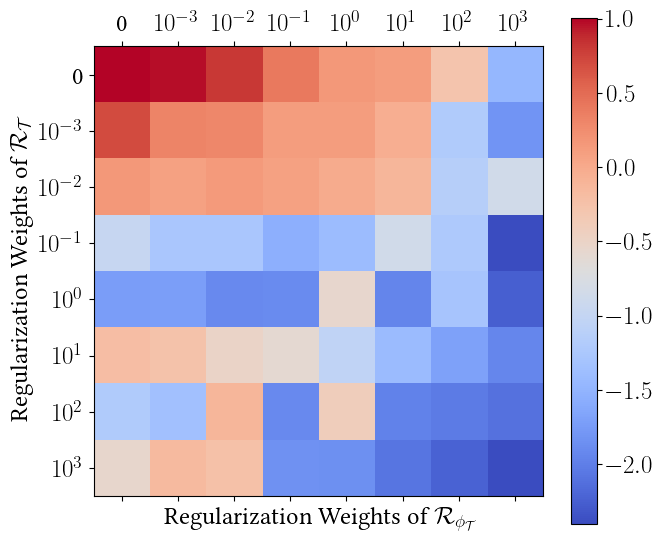

In [50]:
import pylab as plt
import numpy as np
import seaborn as sns
import numpy as np
from pandas import DataFrame as DF
import pylab as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "libertine",
    "font.size": 18,
    'font.serif': 'Linux Libertine',
    'text.latex.preamble':  r'\usepackage{libertine}'
})

alphas = [0.0, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]  # Example alphas
regs = [0.0, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]  # Example regs

# Define a function to format the tick labels in scientific notation
def sci_format(x, pos):
    if x == 0:
        return "0"
    else:
        return r'$10^{%d}$' % np.log10(x)

sci_formatter = FuncFormatter(sci_format) 

# Show results in a heatmap
fig, ax = plt.subplots(figsize=(7, 6))
cax = ax.matshow([[results[alpha][reg] for reg in regs] for alpha in alphas], cmap='coolwarm')
# The colorbar size is defined by the axes size
fig.colorbar(cax, ax=ax)


ax.set_xticklabels(regs)
ax.set_yticklabels(alphas)

# Setting the tick positions
ax.set_xticks(np.arange(len(regs)))
ax.set_yticks(np.arange(len(alphas)))

# Applying the formatter to the axes
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: sci_format(regs[int(x)], pos)))  # Apply the formatter to x-axis for reg values
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: sci_format(alphas[int(x)], pos)))  # y-axis for alpha values

# Show the ticks in scientific notation 
plt.xlabel(r'Regularization Weights of $\mathcal{R}_{\mathcal{\phi}_\mathcal{T}}$')
plt.ylabel(r'Regularization Weights of $\mathcal{R}_\mathcal{T}$')
# plt.title(r'SLC-AUC')
plt.tight_layout()
plt.savefig('SLC-AUC-heatmap.pdf')
plt.show()